Uniform in x, y - mixture of sech^2 in z


In [88]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import quad, tplquad
from scipy.interpolate import interp1d

from pyia import GaiaData

In [40]:
def ln_prob_density(z, ln_N0, h1, h2, f):
    lnterm1 = np.log(f) - 2 * np.log(np.cosh(z / (2 * h1))) - np.log(4 * h1)
    lnterm2 = np.log(1 - f) - 2 * np.log(np.cosh(z / (2 * h2))) - np.log(4 * h2)
    return ln_N0 + np.logaddexp(lnterm1, lnterm2)

In [27]:
usys = [u.pc, u.rad, u.Msun, u.Myr]

zgrid = np.linspace(-5e3, 5e3, 1024)
rho = np.exp(ln_prob_density(zgrid, ln_N0=0., h1=200., h2=800., f=0.3))

Text(0.5, 0, '$z$ [pc]')

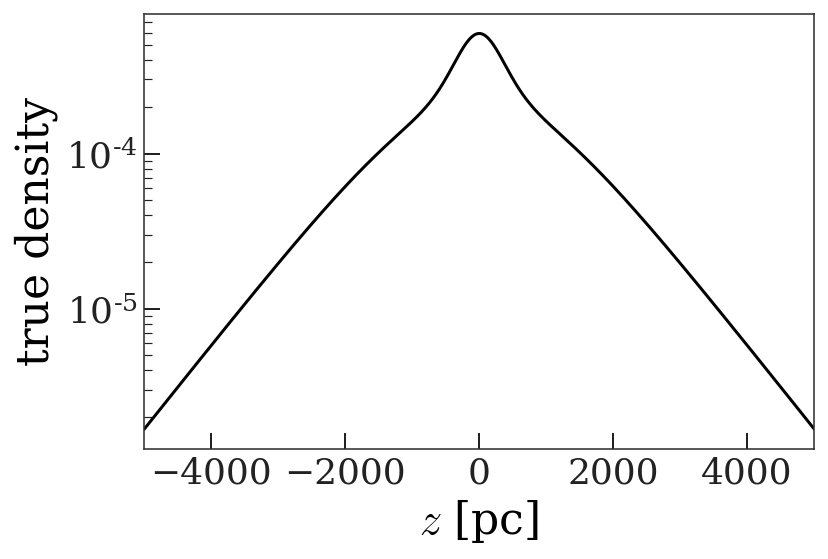

In [28]:
plt.figure(figsize=(6, 4))
plt.plot(zgrid, rho, marker='')
plt.xlim(zgrid.min(), zgrid.max())
plt.yscale('log')
plt.ylabel('true density')
plt.xlabel('$z$ [pc]')

Inverse transform sampling to generate "true" z values for simulation:

In [30]:
def invt_sample_z(density, size=1, 
                  grid_lim=[-5, 5]*u.kpc, grid_size=256, 
                  args=(), rng=None):
    
    if rng is None:
        rng = np.random.default_rng()
    
    zgrid = np.linspace(*grid_lim.to_value(u.pc), grid_size)
    pdf = density(zgrid, *args)
    cdf = np.array([
        quad(density, -np.inf, zz, args=args, limit=1024, epsabs=1e-10)[0] 
        for zz in zgrid
    ])
    
    interp_f = interp1d(cdf, zgrid, kind='cubic')
    z_samples = interp_f(rng.uniform(cdf.min(), cdf.max(), size=size))
    return z_samples

In [31]:
rng = np.random.default_rng(seed=42)
truth = {
    'h1': 200 * u.pc,
    'h2': 800 * u.pc,
    'f': 0.3,
    'x_sigma': 0.5,
    'y_sigma': 0.5,
}
true_args = list(truth.values())

In [32]:
N = 100_000

args = (0., truth['h1'].value, truth['h2'].value, truth['f'])
z_samples = invt_sample_z(
    lambda *args: np.exp(ln_prob_density(*args)), 
    args=args, 
    size=N
) * u.pc

# x_samples = rng.uniform(-1, 1, size=N) * u.kpc
# y_samples = rng.uniform(-1, 1, size=N) * u.kpc
x_samples = rng.normal(0, truth['x_sigma'], size=N) * u.kpc
y_samples = rng.normal(0, truth['y_sigma'], size=N) * u.kpc
xyz_samples = np.stack((x_samples, y_samples, z_samples), axis=0)

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in cosh
  # Remove the CWD from sys.path while we load stuff.
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in cosh
  # This is added back by InteractiveShellApp.init_path()


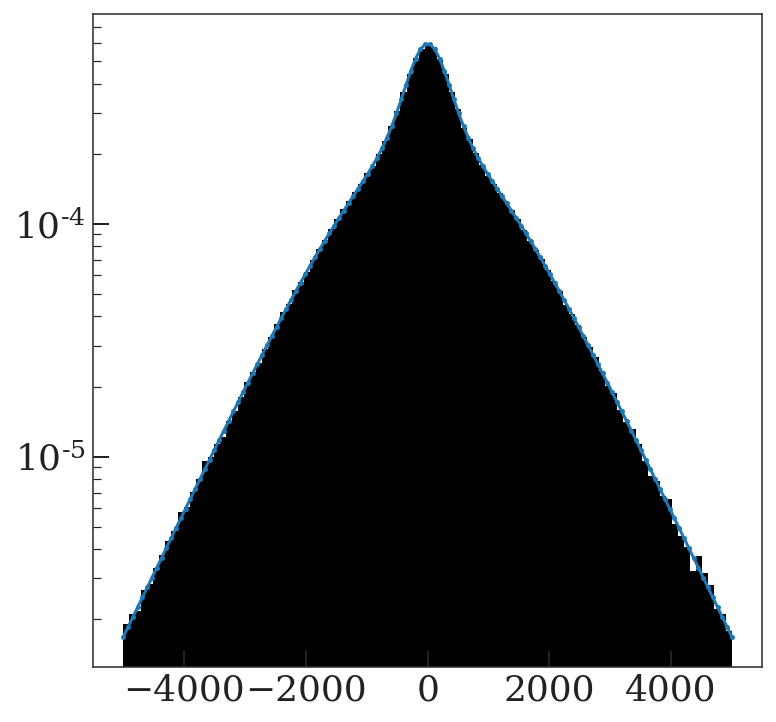

In [34]:
plt.hist(z_samples.value, bins=101, density=True);

_zgrid = np.linspace(-5000, 5000, 128)
shit = ln_prob_density(_zgrid, 0., truth['h1'].value, truth['h2'].value, truth['f'])
plt.plot(_zgrid, np.exp(shit))

plt.yscale('log')

In [35]:
from astropy.coordinates.matrix_utilities import (
    rotation_matrix,
    matrix_product
)


def get_M(sgrA_star, zsun, roll):
    # This matrix goes from "Galactic" to Shmagalactic
    lat_mat = rotation_matrix(-sgrA_star.lat, 'y')
    lon_mat = rotation_matrix(sgrA_star.lon, 'z')
    roll_mat = rotation_matrix(roll, 'x')
    
    # construct transformation matrix and use it
    R = matrix_product(roll_mat, lat_mat, lon_mat)

    # Now need to account for tilt due to Sun's height above the plane
    z_d = zsun / sgrA_star.distance
    H = rotation_matrix(-np.arcsin(z_d), 'y')

    # compute total matrices
    M = matrix_product(H, R)

    return M


# schmagal = Galactocentric but at the solar position
# gal = Galactic
def gal_to_schmagal(xyz, sgrA_star, zsun, roll):
    M = get_M(sgrA_star, zsun, roll)
    new_xyz = M @ xyz - ([0, 0, zsun.value] * zsun.unit)[:, None]
    return new_xyz
    

def schmagal_to_gal(xyz, sgrA_star, zsun, roll):
    MT = get_M(sgrA_star, zsun, roll).T
    new_xyz = MT @ (xyz + ([0, 0, zsun.value] * zsun.unit)[:, None])
    return new_xyz

In [36]:
truth['zsun'] = 174.35 * u.pc
truth['roll'] = 15.3 * u.deg
truth['sgrA'] = coord.SphericalRepresentation(0.528 * u.deg, -0.17*u.deg, 8.1 * u.kpc)

sim_schmagal = coord.CartesianRepresentation(xyz_samples)

sim_gal = coord.CartesianRepresentation(
    schmagal_to_gal(xyz_samples, 
                    truth['sgrA'], truth['zsun'], truth['roll'])
)
sim_gal_sph = sim_gal.represent_as(coord.SphericalRepresentation)

In [89]:
maxdist = 1 * u.kpc

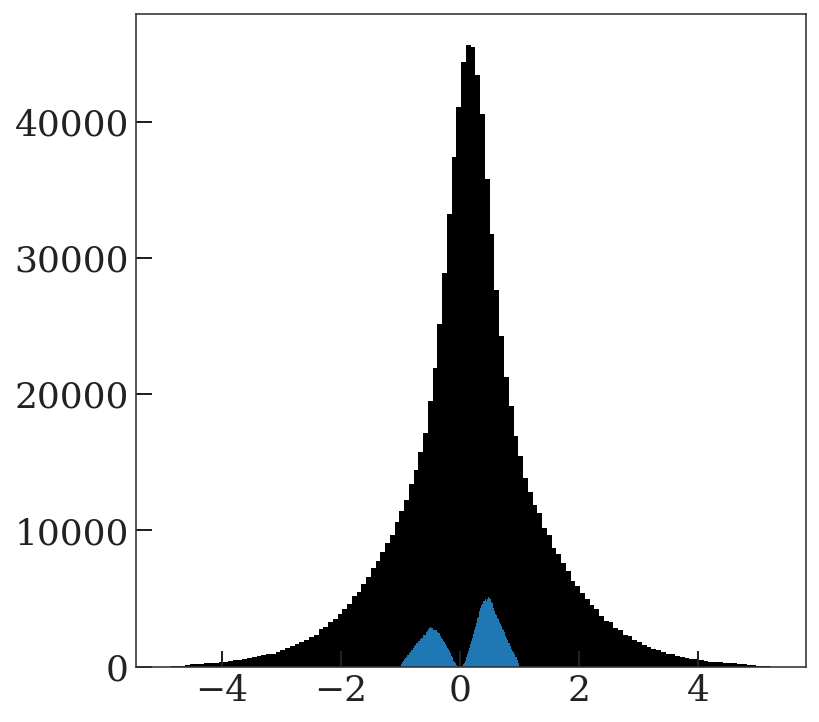

In [42]:
plt.hist(sim_gal.z.value, bins=128);
plt.hist(sim_gal.z.value[sim_mask], bins=128);

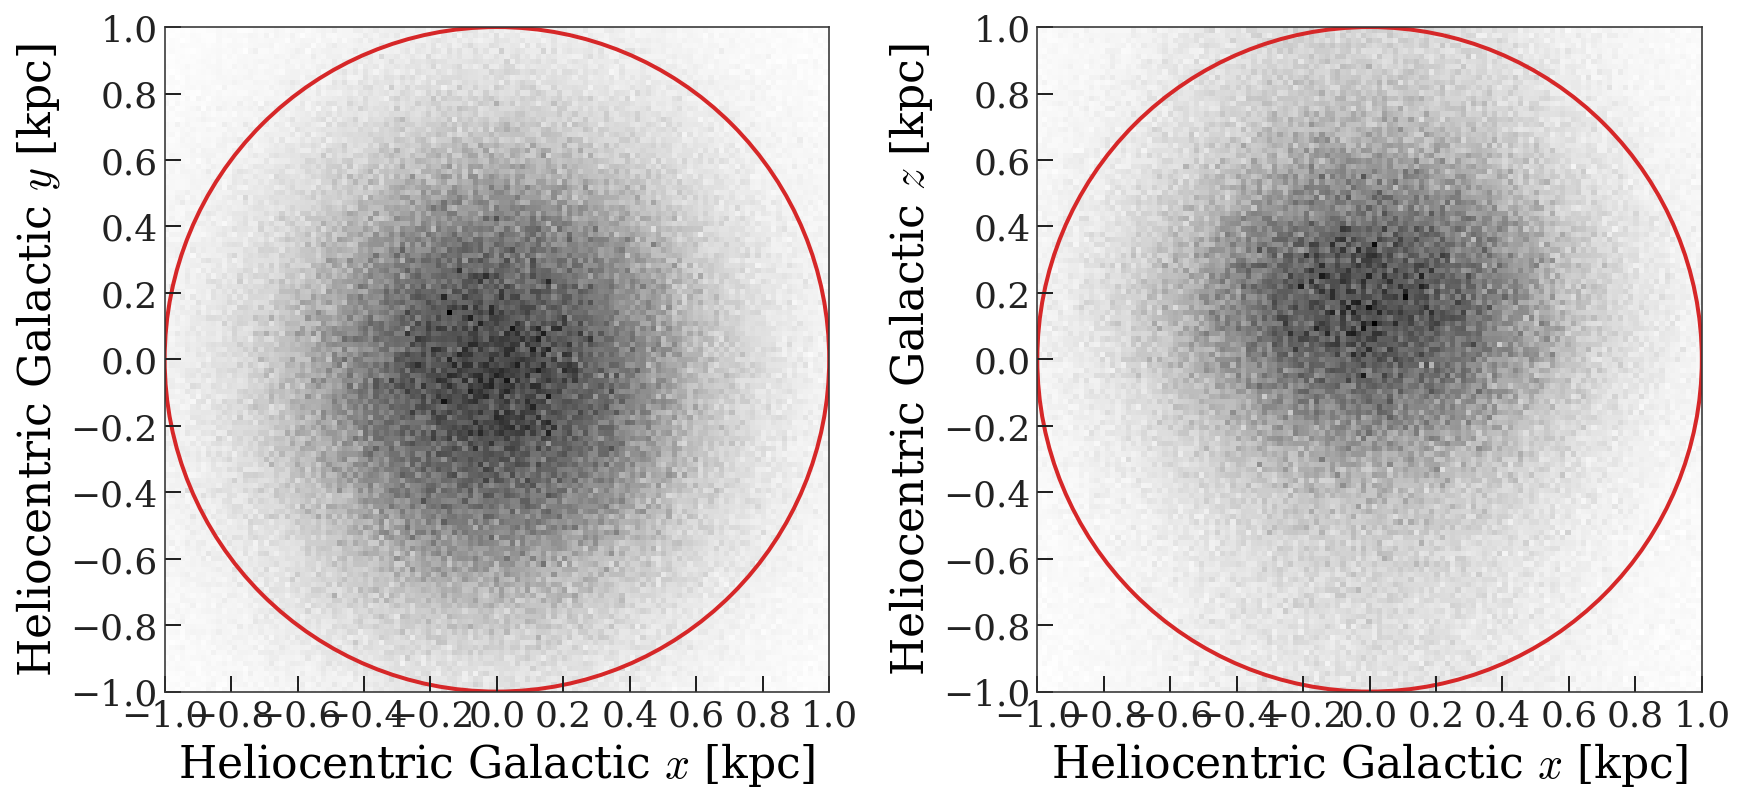

In [90]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(12, 6), 
    constrained_layout=True
)

lim = (-1, 1)
for ax, coords, labels in zip(axes, 
                              [(sim_gal.x.value, 
                                sim_gal.y.value), 
                               (sim_gal.x.value, 
                                sim_gal.z.value)], 
                              [('x', 'y'), ('x', 'z')]):
    ax.hist2d(
        coords[0], 
        coords[1], 
        bins=np.linspace(*lim, 128), 
        cmap='Greys'
    #     norm=mpl.colors.LogNorm()
    )

    circ = mpl.patches.Circle(
        (0, 0),
        radius=maxdist.to_value(u.kpc),
        linewidth=2, 
        facecolor='none',
        edgecolor='tab:red'
    )
    ax.add_patch(circ)
    ax.set_aspect('equal')
    
    ax.set(
        xlabel=f'Heliocentric Galactic ${labels[0]}$ [kpc]',
        ylabel=f'Heliocentric Galactic ${labels[1]}$ [kpc]',
        xlim=lim,
        ylim=lim,
        xticks=np.arange(lim[0], lim[1]+0.1, 0.2),
        yticks=np.arange(lim[0], lim[1]+0.1, 0.2)
    );

In [66]:
def ln_normal(x, mu, std):
    return -0.5 * (x-mu)**2 / std**2 - 0.5*np.log(2*np.pi) - np.log(std)


def ln_likelihood(p, xyz, sgrA_star, plot=False):
    lnn0, lnh1, lnh2, f, zsun, roll = p
    
    rot_xyz = gal_to_schmagal(xyz * u.pc, 
                              sgrA_star, 
                              zsun * u.pc, 
                              roll * u.rad).to_value(u.pc)
    
    if plot:
        grid = np.linspace(-5000, 5000, 128)
        plt.hist(rot_xyz[2], bins=grid, density=True);

        val = np.exp(ln_prob_density(grid, 0, np.exp(lnh1), np.exp(lnh2), f))
        plt.plot(grid, val, marker='')
        plt.yscale('log')
    # print(rot_xyz[2] - z_samples.value)

    term1 = - np.exp(lnn0) + xyz.shape[1] * lnn0
    term2 = ln_prob_density(rot_xyz[2], 0, np.exp(lnh1), np.exp(lnh2), f).sum()
    term3 = (ln_normal(rot_xyz[0], 0, truth['x_sigma']).sum() + 
             ln_normal(rot_xyz[1], 0, truth['y_sigma']).sum())
    
    return term1 + term2 + term3

-999723638826.747

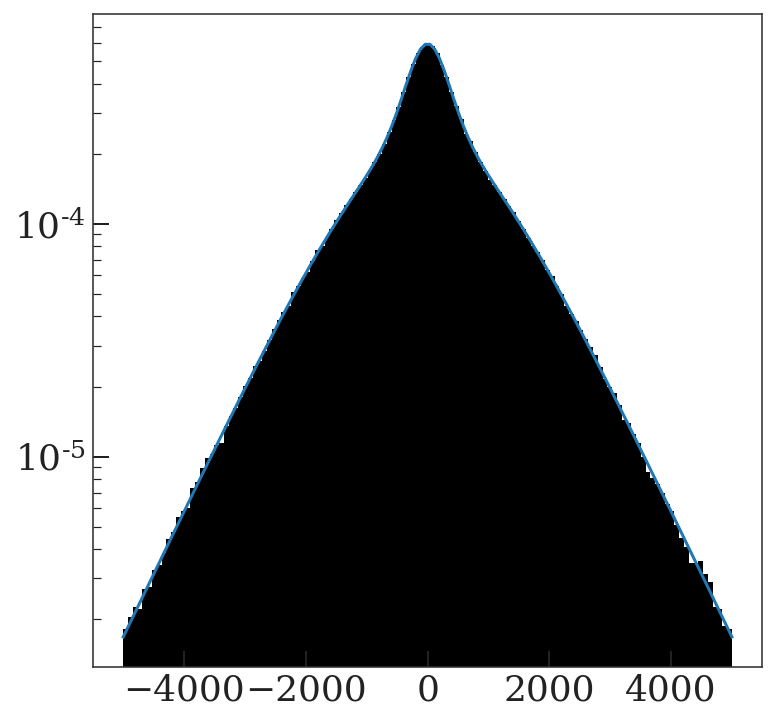

In [67]:
p0 = (
    np.log(sim_gal.shape[0]),
    np.log(truth['h1'].decompose(usys).value),
    np.log(truth['h2'].decompose(usys).value),
    truth['f'],
    truth['zsun'].decompose(usys).value,
    truth['roll'].decompose(usys).value
)
p0_names = (
    'lnn0',
    'lnh1',
    'lnh2',
    'f',
    'zsun',
    'roll'
)
ln_likelihood(p0, sim_gal.xyz.decompose(usys).value, truth['sgrA'], plot=True)

In [64]:
%load_ext line_profiler

In [70]:
%timeit ln_likelihood(p0, sim_gal.xyz.decompose(usys).value, truth['sgrA'])

184 ms ± 95.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


-1000839327577.0092

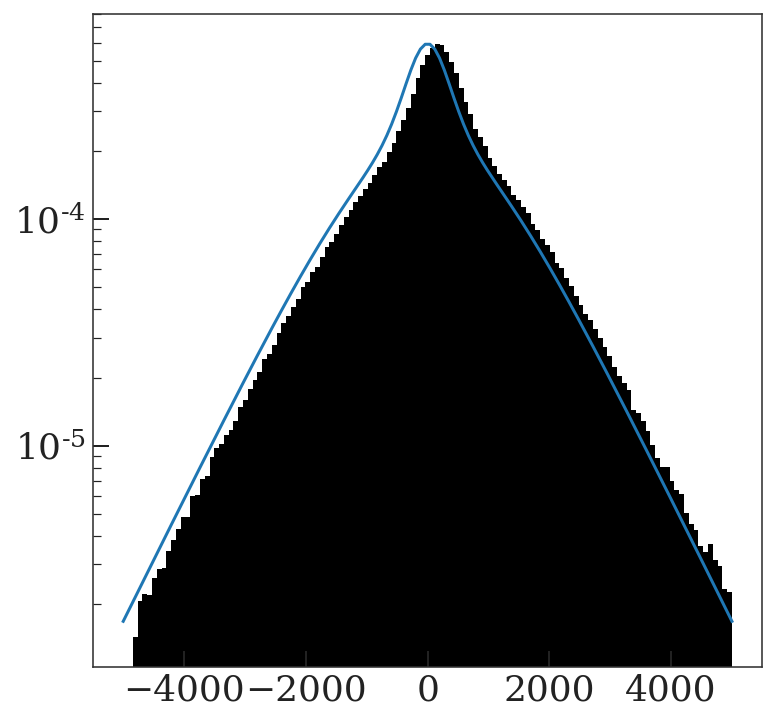

In [63]:
wtf_p0 = np.array(p0, copy=True)
wtf_p0[4] = 1.9
ln_likelihood(wtf_p0, sim_gal.xyz.decompose(usys).value, truth['sgrA'], plot=True)

In [71]:
zdata = sim_gal.xyz.decompose(usys).value
sgrA = truth['sgrA']

all_vals = np.array([
    np.linspace(0.9, 1.1, 16) * p0[0],
    np.linspace(0.9, 1.1, 16) * p0[1],
    np.linspace(0.9, 1.1, 16) * p0[2],
#     np.linspace(-50, 250, 16),
    np.linspace(0.9, 1.1, 16) * p0[3],
#     np.linspace(-np.pi, np.pi, 16),
    np.linspace(0.9, 1.1, 16) * p0[4],
    np.linspace(0.9, 1.1, 16) * p0[5],
])

all_lls = []
for i in range(len(p0)):
    this_p0 = np.array(p0, copy=True)
    lls = []
    vals = all_vals[i]
    for val in vals:
        this_p0[i] = val
        lls.append(ln_likelihood(this_p0, zdata, sgrA))
    all_lls.append(lls)
all_lls = np.array(all_lls)

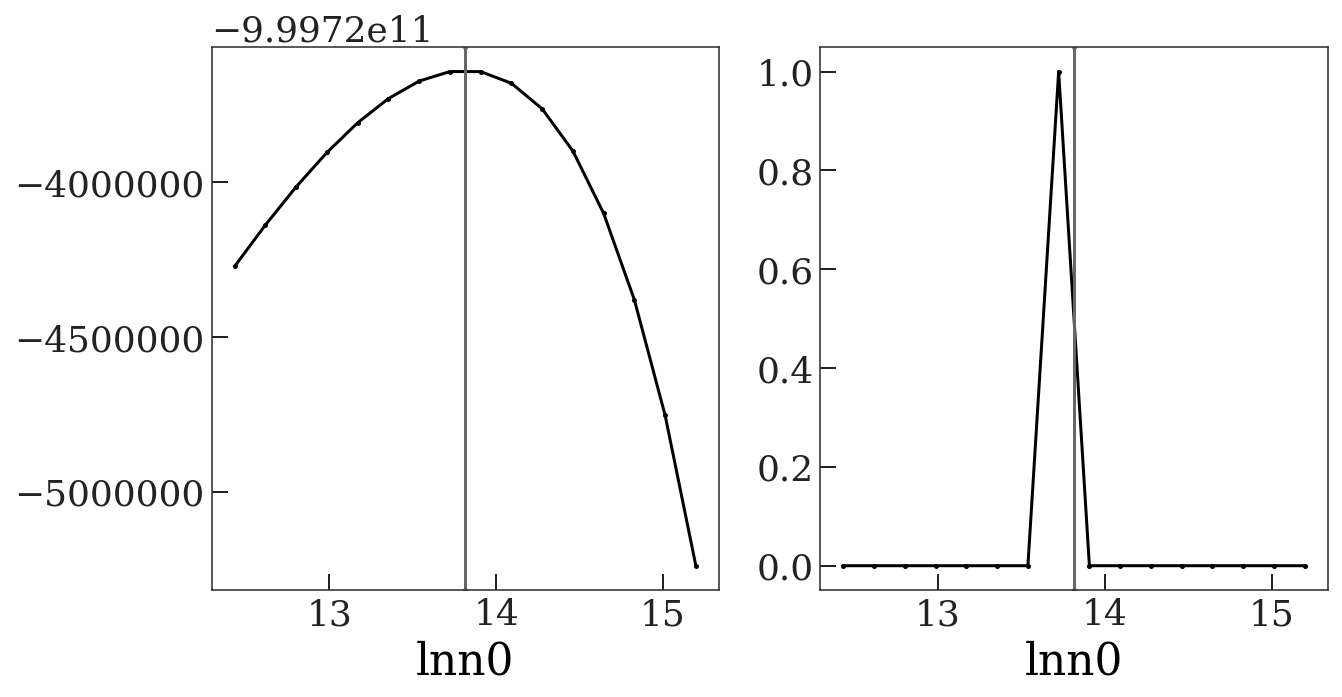

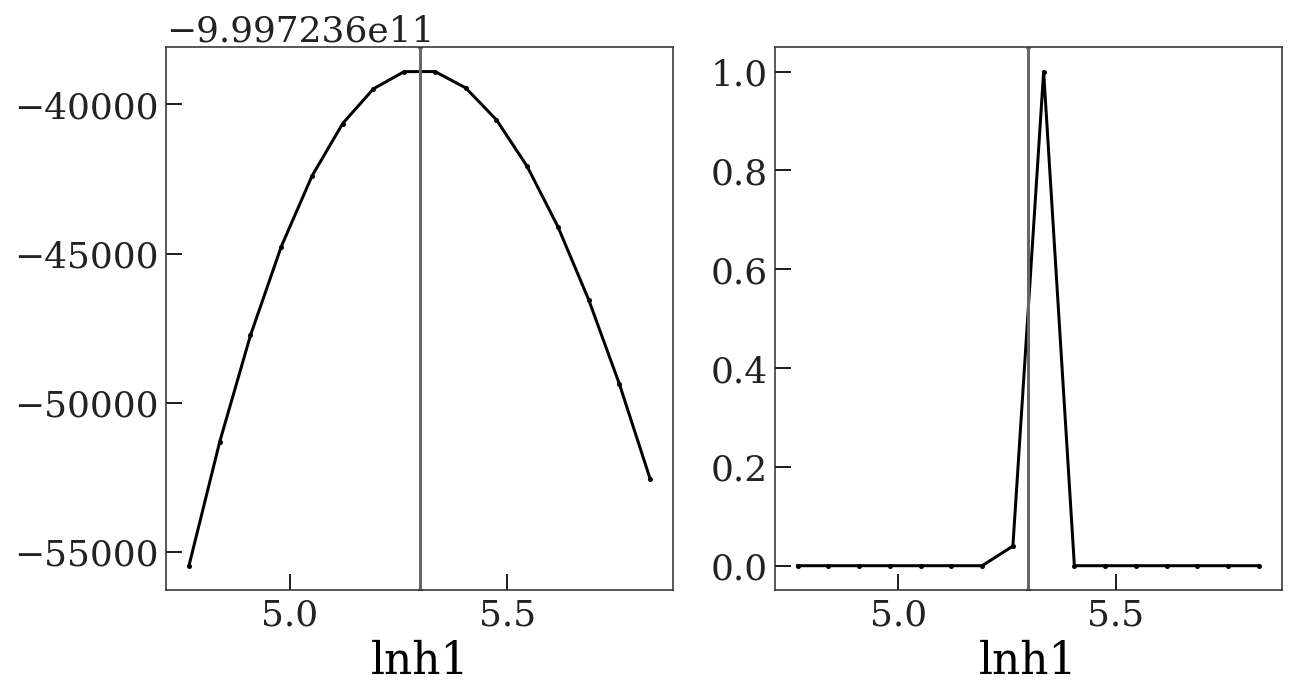

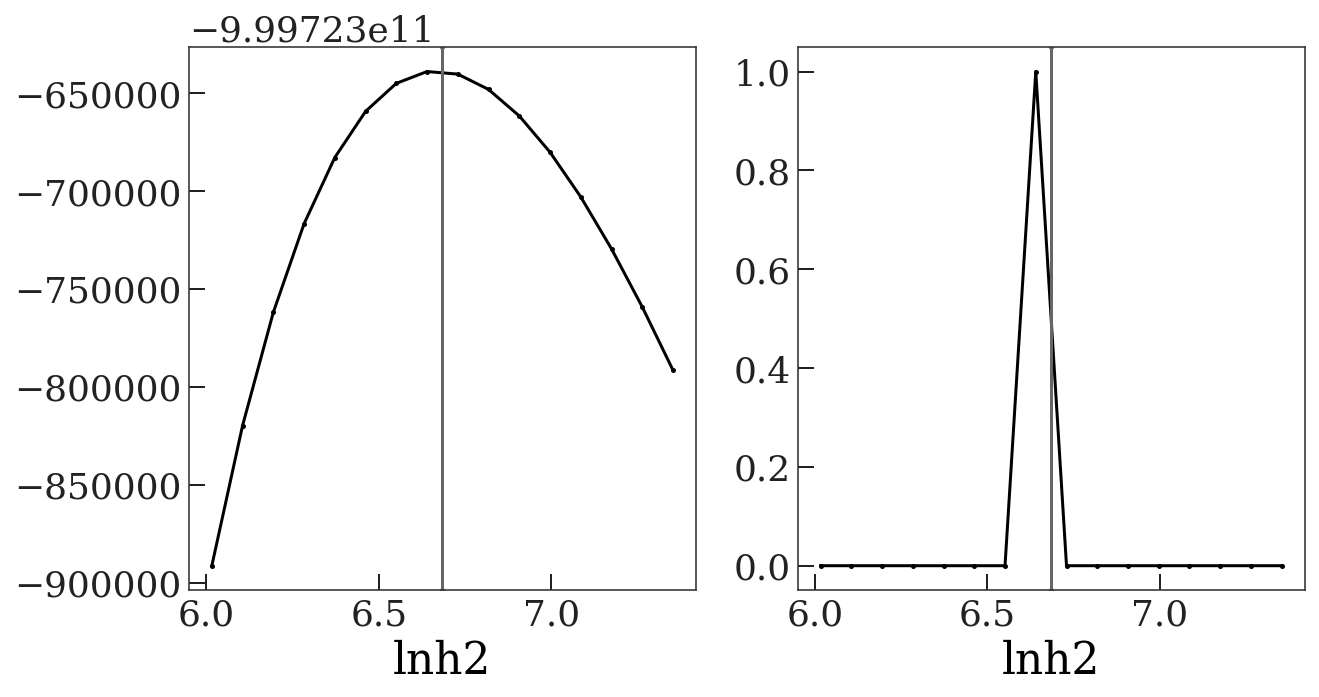

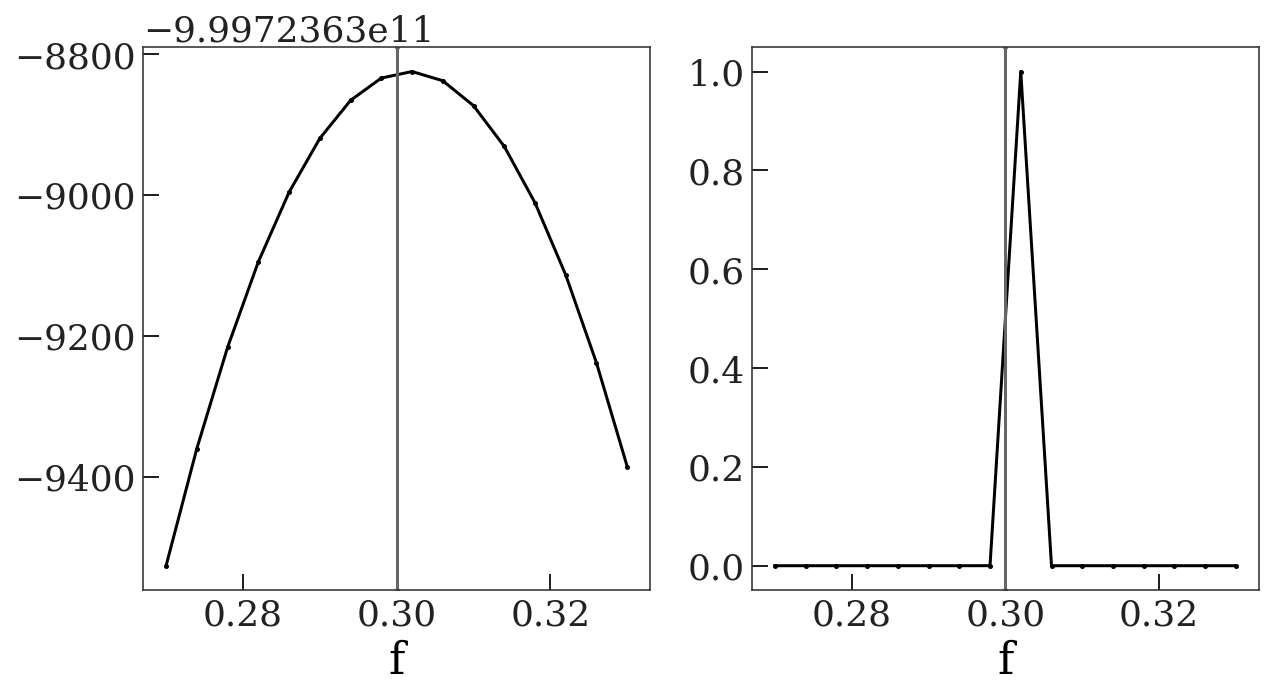

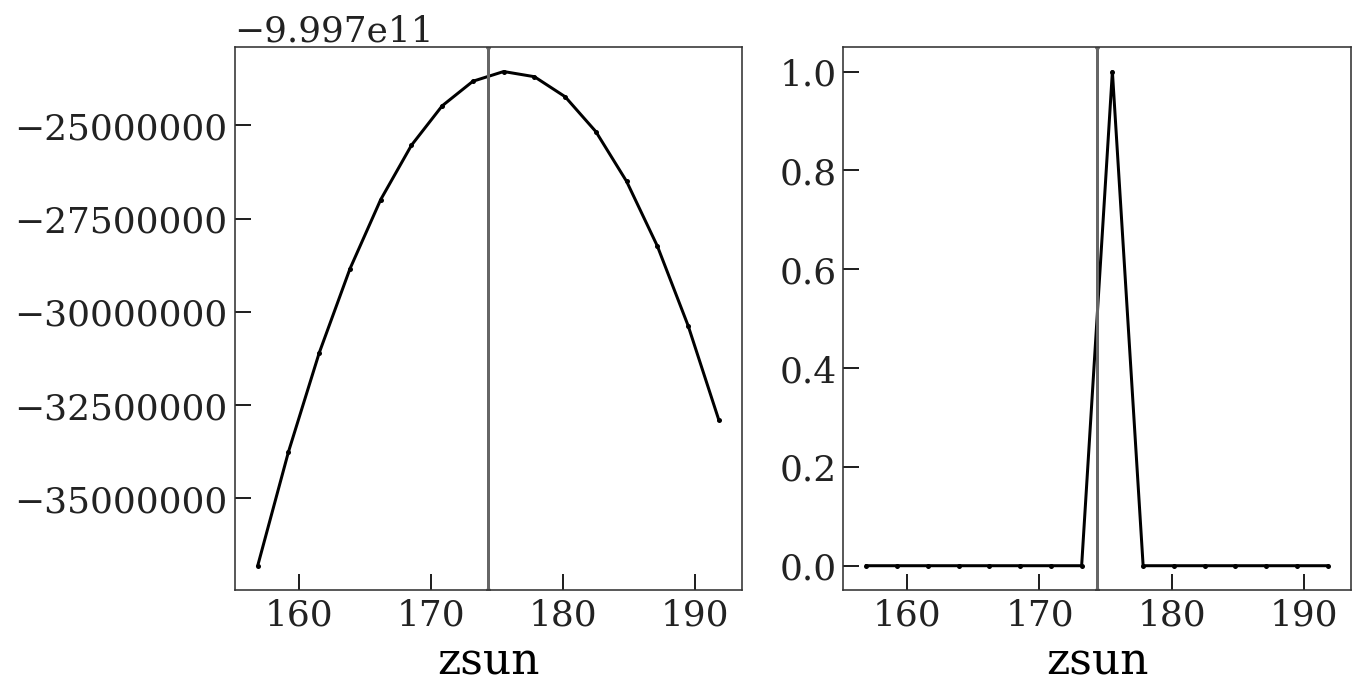

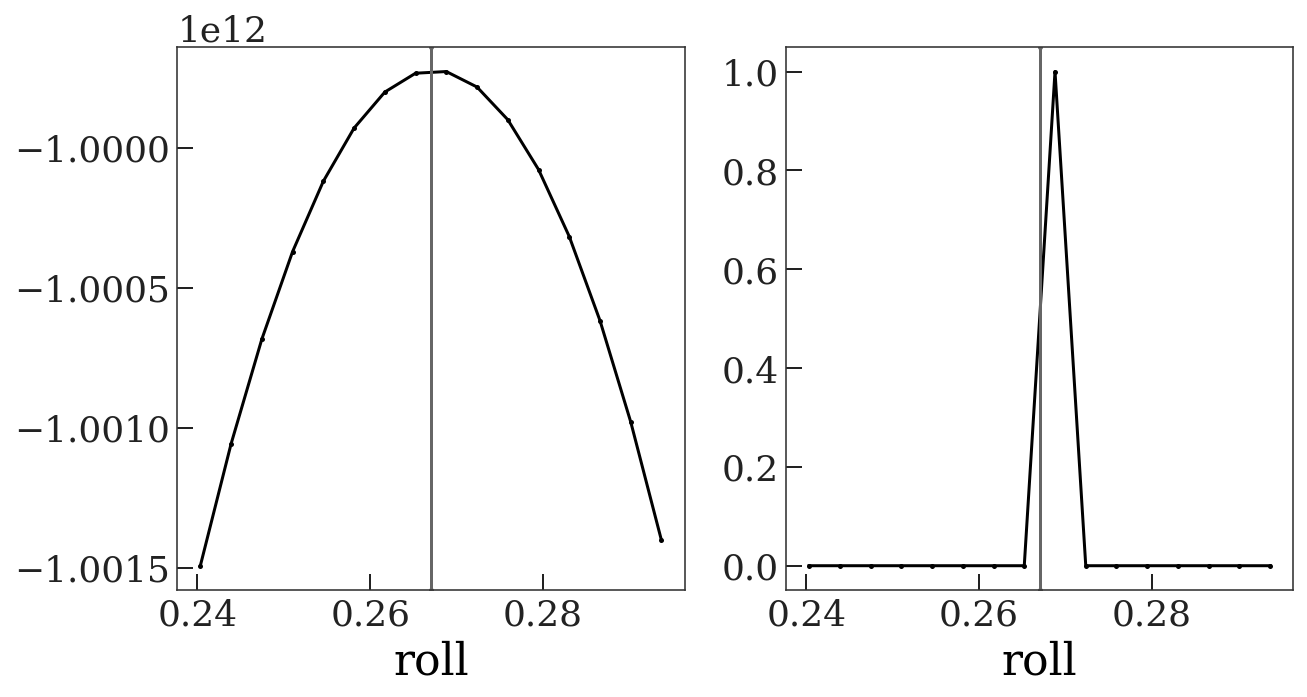

In [72]:
for i in range(len(p0)):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(all_vals[i], all_lls[i])
    axes[1].plot(all_vals[i], np.exp(all_lls[i] - all_lls[i].max()))
    for ax in axes:
        ax.set_xlabel(p0_names[i])
        ax.axvline(p0[i])

In [73]:
full_res = minimize(
    lambda *args: -ln_likelihood(*args), 
    x0=p0, 
    args=(sim_gal.xyz.decompose(usys).value, truth['sgrA']), 
    method='nelder-mead'
)

In [74]:
rng = np.random.default_rng(seed=42)

bootstrap_res = []
for i in range(2):
    print(i, end='\r')
    batch = sim_gal.xyz.decompose(usys).value[:, rng.choice(N, size=N)]
    res = minimize(lambda *args: -ln_likelihood(*args), 
                   x0=p0, args=(batch, truth['sgrA']), 
                   method='nelder-mead')
    bootstrap_res.append(res)

In [75]:
np.all([res.success for res in bootstrap_res])

False

In [77]:
bootstrap_optp = np.array([res.x for res in bootstrap_res])

-999723638826.747

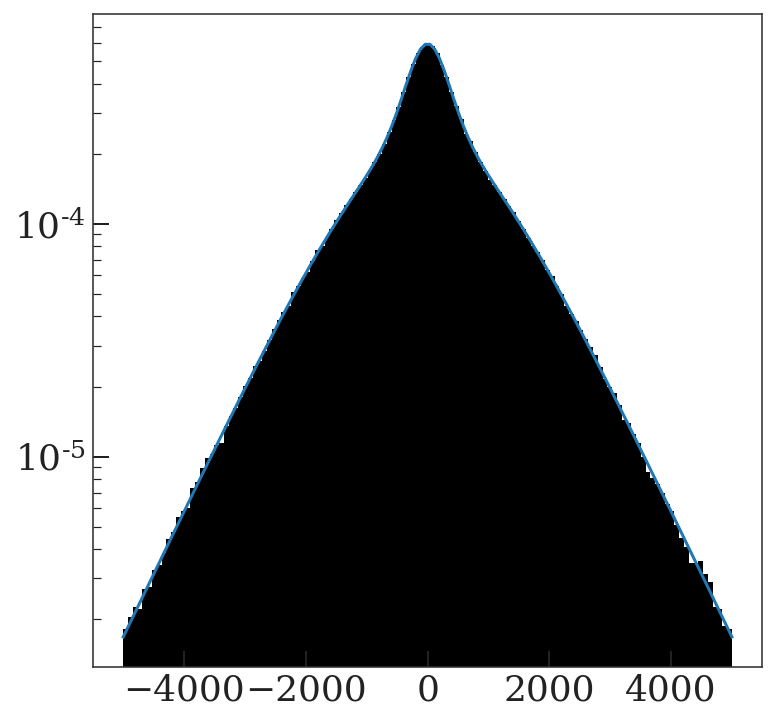

In [78]:
ln_likelihood(p0, sim_gal.xyz.decompose(usys).value, truth['sgrA'], plot=True)

-999723661142.4369

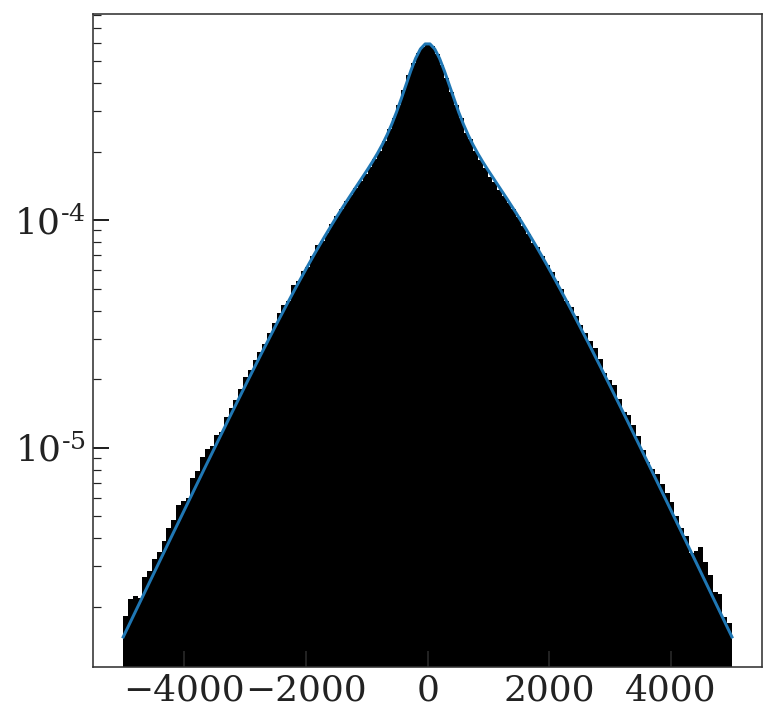

In [81]:
ln_likelihood(bootstrap_optp[0], sim_gal.xyz.decompose(usys).value, truth['sgrA'], plot=True)

In [82]:
import corner

In [87]:
np.array(p0)

array([ 13.81551056,   5.29831737,   6.68461173,   0.3       ,
       174.35      ,   0.26703538])

In [85]:
full_res.x

array([ 13.81550813,   5.25485558,   6.65439308,   0.28099733,
       175.86794844,   0.26738486])

In [84]:
bootstrap_optp

array([[ 13.81551774,   5.26074663,   6.65475448,   0.28321421,
        178.91686151,   0.26754247],
       [ 13.81553041,   5.24708775,   6.65391198,   0.27820873,
        176.96600346,   0.26721203]])

In [83]:
_ = corner.corner(bootstrap_optp, truths=p0, data_kwargs=dict(alpha=1),
                  range=np.array([0.75, 1.25])[None] * np.array(p0)[:, None],
                  plot_contours=False, plot_density=False)

AssertionError: I don't believe that you want more dimensions than samples!